In this project, we will walk through the full data science life cycle, from data cleaning and feature selection to machine learning. We will focus on credit modelling, a well known data science problem that focuses on modeling a borrower's [credit risk](https://en.wikipedia.org/wiki/Credit_risk). Credit has played a key role in the economy for centuries and some form of credit has existed since the beginning of commerce. We'll be working with financial lending data from [Lending Club](https://www.lendingclub.com/). Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. We can read more about their marketplace [here](https://www.lendingclub.com/public/how-peer-lending-works.action).

Each borrower fills out a comprehensive application, providing their past financial history, the reason for the loan, and more. Lending Club evaluates each borrower's credit score using past historical data (and their own data science process!) and assign an interest rate to the borrower. The interest rate is the percent in addition to the requested loan amount the borrower has to pay back. We can read more about the interest rate that Lending Club assigns [here](https://www.lendingclub.com/loans/personal-loans/rates-fees?). Lending Club also tries to verify each piece of information the borrower provides but it can't always verify all of the information (usually for regulation reasons).

A higher interest rate means that the borrower is riskier and more unlikely to pay back the loan while a lower interest rate means that the borrower has a good credit history is more likely to pay back the loan. The interest rates range from 5.32% all the way to 30.99% and each borrower is given a [grade](https://www.lendingclub.com/investing/investor-education/interest-rates-and-fees) according to the interest rate they were assigned. If the borrower accepts the interest rate, then the loan is listed on the Lending Club marketplace.

Investors are primarily interested in receiveing a return on their investments. Once they're ready to back a loan, they select the amount of money they want to fund. Once a loan's requested amount is fully funded, the borrower receives the money they requested minus the [origination fee](https://help.lendingclub.com/hc/en-us/articles/214501207-What-is-the-origination-fee-) that Lending Club charges.

The borrower then makes monthly payments back to Lending Club either over 36 months or over 60 months. Lending Club redistributes these payments to the investors. This means that investors don't have to wait until the full amount is paid off to start to see money back. If a loan is fully paid off on time, the investors make a return which corresponds to the interest rate the borrower had to pay in addition the requested amount. Many loans aren't completely paid off on time, however, and some borrowers default on the loan.

Most investors use a portfolio strategy to invest small amounts in many loans, with healthy mixes of low, medium, and interest loans. In this project, we'll focus on the mindset of a conservative investor who only wants to invest in the loans that have a good chance of being paid off on time. To do that, we'll need to first understand the features in the dataset and then experiment with building machine learning models that reliably predict if a loan will be paid off or not.

Lending Club releases data for all of the approved and declined loan applications periodically on their [website](https://www.lendingclub.com/auth/login?login_url=%2Finfo%2Fdownload-data.action). We can select a few different year ranges to download the datasets (in CSV format) for both approved and declined loans.

We'll also find a data dictionary (in XLS format) which contains information on the different column names towards the bottom of the page. Here's a link to the data dictionary file hosted on [Google Drive](https://docs.google.com/spreadsheets/d/191B2yJ4H1ZPXq0_ByhUgWMFZOYem5jFz0Y3by_7YBY4/edit).

Before diving into the datasets themselves, let's get familiar with the data dictionary. The **LoanStats** sheet describes the approved loans datasets and the **RejectStats** describes the rejected loans datasets. Since rejected applications don't appear on the Lending Club marketplace and aren't available for investment, we'll be focusing on data on approved loans only.

The approved loans datasets contain information on current loans, completed loans, and defaulted loans. Let's now define the problem statement for this machine learning project:

* Can we build a machine learning model that can accurately predict if a borrower will pay off their loan on time or not?

Before we can start doing machine learning, we need to define what features we want to use and which column repesents the target column we want to predict.

In this project, we'll focus on approved loans data from 2007 to 2011, since a good number of the loans have already finished. In the datasets for later years, many of the loans are current and still being paid off.

We have reduced the size of the dataset to make it easier to work with, by:

* removing the desc column:
 * which contains a long text explanation for each loan
* removing the url column:
 * which contains a link to each loan on Lending Club which can only be accessed with an investor account
* removing all columns containing more than 50% missing values:
 * which allows us to move faster since we can spend less time trying to fill these values

In [18]:
import pandas as pd
loans_2007 = pd.read_csv("loans_2007.csv")
loans_2007.drop_duplicates()
# print(loans_2007.iloc[0])
print(loans_2007.shape[1])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


52


The Dataframe contains many columns and can be cumbersome to try to explore all at once. Let's break up the columns into 3 groups of 18 columns and use the [data dictionary](https://docs.google.com/spreadsheets/d/191B2yJ4H1ZPXq0_ByhUgWMFZOYem5jFz0Y3by_7YBY4/edit) to become familiar with what each column represents.

As we understand each feature, we want to pay attention to any features that:

* leak information from the future (after the loan has already been funded)
* don't affect a borrower's ability to pay back a loan (e.g. a randomly generated ID value by Lending Club)
* formatted poorly and need to be cleaned up
* require more data or a lot of processing to turn into a useful feature
* contain redundant information

We need to especially pay attention to data leakage, since it can cause our model to overfit. This is because the model would be using data about the target column that wouldn't be available when we're using the model on future loans. That is why we need to understand each column, because a poor understanding could cause us to make mistakes in the data analysis and modeling process. As we go through the dictionary, keep in mind that we need to select one of the columns as the target column we want to use when we move on to the machine learning phase.

let's focus on just columns that we need to remove from consideration. Then, we can circle back and further dissect the columns we decided to keep.

After analyzing first 18 columns, we can conclude that the following features need to be removed:

* id: randomly generated field by Lending Club for unique identification purposes only
* member_id: also a randomly generated field by Lending Club for unique identification purposes only
* funded_amnt: leaks data from the future (after the loan is already started to be funded)
* funded_amnt_inv: also leaks data from the future (after the loan is already started to be funded)
* grade: contains redundant information as the interest rate column (int_rate)
* sub_grade: also contains redundant information as the interest rate column (int_rate)
* emp_title: requires other data and a lot of processing to potentially be useful
* issue_d: leaks data from the future (after the loan is already completed funded)

Recall that Lending Club assigns a grade and a sub-grade based on the borrower's interest rate. While the grade and sub_grade values are categorical, the int_rate column contains continuous values, which are better suited for machine learning.

In [19]:
drop_cols = ["id", "member_id", "funded_amnt", "funded_amnt_inv", "grade", "sub_grade", "emp_title", "issue_d"]

loans_2007.drop(drop_cols, axis = 1, inplace = True)

Let's now look at the next 18 columns:

Within this group of columns, we need to drop the following columns:

* zip_code: redundant with the addr_state column since only the first 3 digits of the 5 digit zip code are visible (which only can be used to identify the state the borrower lives in)
* out_prncp: leaks data from the future, (after the loan already started to be paid off)
* out_prncp_inv: also leaks data from the future, (after the loan already started to be paid off)
* total_pymnt: also leaks data from the future, (after the loan already started to be paid off)
* total_pymnt_inv: also leaks data from the future, (after the loan already started to be paid off)
* total_rec_prncp: also leaks data from the future, (after the loan already started to be paid off)

The out_prncp and out_prncp_inv both describe the outstanding principal amount for a loan, which is the remaining amount the borrower still owes. These 2 columns as well as the total_pymnt column describe properties of the loan after it's fully funded and started to be paid off. This information isn't available to an investor before the loan is fully funded and we don't want to include it in our model.

In [20]:
drop_cols = ["zip_code", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp"]

loans_2007 = loans_2007.drop(drop_cols, axis = 1)

In the last group of columns, we need to drop the following columns:

* total_rec_int: leaks data from the future, (after the loan already started to be paid off),
* total_rec_late_fee: also leaks data from the future, (after the loan already started to be paid off),
* recoveries: also leaks data from the future, (after the loan already started to be paid off),
* collection_recovery_fee: also leaks data from the future, (after the loan already started to be paid off),
* last_pymnt_d: also leaks data from the future, (after the loan already started to be paid off),
* last_pymnt_amnt: also leaks data from the future, (after the loan already started to be paid off).

All of these columns leak data from the future, meaning that they're describing aspects of the loan after it's already been fully funded and started to be paid off by the borrower.



In [21]:
drop_cols = ["total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt"]

loans_2007 = loans_2007.drop(drop_cols, axis = 1)

print(loans_2007.shape[1])

32


We now need to decide on a target column that we want to use for modeling.

We should use the loan_status column, since it's the only column that directly describes if a loan was paid off on time, had delayed payments, or was defaulted on the borrower. Currently, this column contains text values and we need to convert it to a numerical one for training a model. 

In [22]:
print(loans_2007["loan_status"].value_counts())

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64


Explanation for each unique value

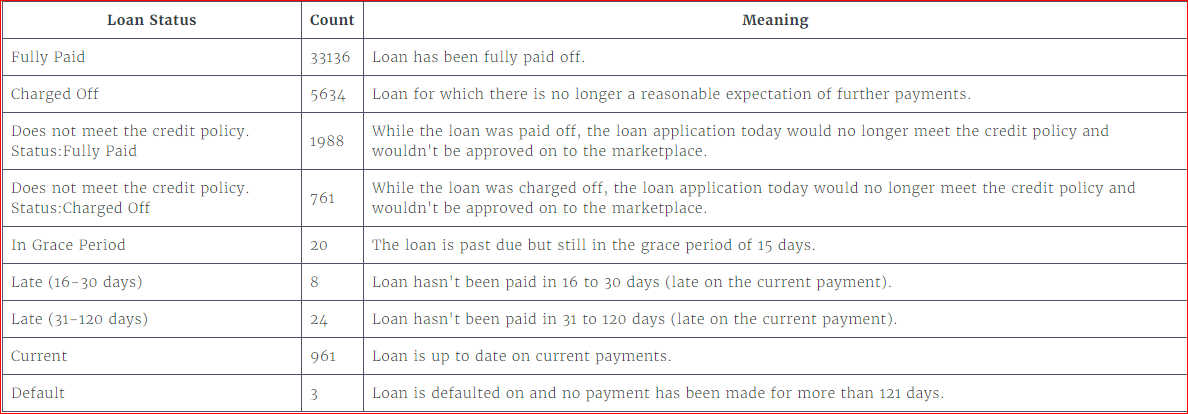

From the investor's perspective, we're interested in trying to predict which loans will be paid off on time and which ones won't be. Only the Fully Paid and Charged Off values describe the final outcome of the loan. The other values describe loans that are still on going and where the jury is still out on if the borrower will pay back the loan on time or not. While the Default status resembles the Charged Off status, in Lending Club's eyes, loans that are charged off have essentially no chance of being repaid while default ones have a small chance.

Since we're interested in being able to predict which of these 2 values a loan will fall under, we can treat the problem as a binary classification one. Let's remove all the loans that don't contain either **Fully Paid** and **Charged Off** as the loan's status and then transform the Fully Paid values to 1 for the positive case and the Charged Off values to 0 for the negative case. While there are a few different ways to transform all of the values in a column, we'll use the [Dataframe method replace](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html).

Lastly, one thing we need to keep in mind is the **class imbalance** between the positive and negative cases. While there are 33,136 loans that have been fully paid off, there are only 5,634 that were charged off. This class imbalance is a common problem in binary classification and during training, the model ends up having a strong bias towards predicting the class with more observations in the training set and will rarely predict the class with less observations. The stronger the imbalance, the more biased the model becomes. There are a few different ways to tackle this class imbalance, which we'll explore later.

In [23]:
loans_2007 = loans_2007[(loans_2007["loan_status"] == "Fully Paid") | (loans_2007["loan_status"] == "Charged Off")]

In [24]:
loans_2007["loan_status"].value_counts()

Fully Paid     33136
Charged Off     5634
Name: loan_status, dtype: int64

In [25]:
status_replace = {"loan_status":{"Fully Paid":1,"Charged Off":0}}

loans_2007 = loans_2007.replace(status_replace)

In [26]:
loans_2007["loan_status"].value_counts()

1    33136
0     5634
Name: loan_status, dtype: int64

Now let's look for any columns that contain only one unique value and remove them. These columns won't be useful for the model since they don't add any information to each loan application. In addition, removing these columns will reduce the number of columns we'll need to explore further.

Since we're trying to find columns that contain one true unique value, we should first drop the null values then compute the number of unique values:

In [27]:
orig_columns = loans_2007.columns

drop_columns = []

for col in orig_columns:
    unique_col = loans_2007[col].dropna().unique()
    if len(unique_col) == 1:
        drop_columns.append(col)
drop_columns    

['pymnt_plan',
 'initial_list_status',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']

In [28]:
loans_2007.drop(drop_columns, axis = 1, inplace = True)

In [31]:
loans_2007.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies
0,5000.0,36 months,10.65%,162.87,10+ years,RENT,24000.0,Verified,1,credit_card,...,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,Jun-2016,0.0
1,2500.0,60 months,15.27%,59.83,< 1 year,RENT,30000.0,Source Verified,0,car,...,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,Sep-2013,0.0
2,2400.0,36 months,15.96%,84.33,10+ years,RENT,12252.0,Not Verified,1,small_business,...,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,Jun-2016,0.0
3,10000.0,36 months,13.49%,339.31,10+ years,RENT,49200.0,Source Verified,1,other,...,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,Apr-2016,0.0
5,5000.0,36 months,7.90%,156.46,3 years,RENT,36000.0,Source Verified,1,wedding,...,0.0,Nov-2004,3.0,9.0,0.0,7963.0,28.3%,12.0,Jan-2016,0.0


It looks we we were able to remove 9 more columns since they only contained 1 unique value.

In this project, we started to become familiar with the columns in the dataset and removed many columns that aren't useful for modeling. We also selected our target column and decided to focus our modeling efforts on binary classification. In the next project, we'll explore the individual features in greater depth and work towards training our first machine learning model.

Let's prepare cleaned datasets for next project

In [30]:
loans_2007.to_csv("filtered_loans_2007.csv",sep = ",",index = False)